##  Kurulum 
Bu proje için anaconda environment kullanılabilir


### Kurulum Adımı
```bash
# Yeni bir environment oluştur ve aktive et (Python 3.13)
conda create -n vm_env python=3.13
conda activate vm_env

# Proje klasörüne git ve gereklilikleri yükle
cd Okyanus_Dalgalarinda_Anomali
pip install -r Requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

%matplotlib inline

# Okyanus Dalgalarında Fırtına Kaynaklı Anomali Tespiti

### Projenin Amacı
Bu çalışma, okyanus şamandıralarından alınan gerçek zamanlı verileri kullanarak fırtına kaynaklı dalga anomalilerini tespit etmeyi amaçlamaktadır. **NOAA NDBC 46047** istasyonundan alınan veriler üzerinde veri madenciliği ve makine öğrenmesi yöntemleri uygulanmıştır.

### 1. Kütüphanelerin Yüklenmesi
Veri analizi, görselleştirme ve makine öğrenmesi modelleri için gerekli kütüphaneler yüklenmektedir.

In [10]:
print("NOAA Sunucularından veri çekiliyor...")

url = "https://www.ndbc.noaa.gov/data/realtime2/46047.txt"

# Sütunların karakter aralıkları (Fixed Width)
colspecs = [
    (0, 4), (5, 7), (8, 10), (11, 13), (14, 16), # Tarih
    (17, 21), (22, 26), (27, 31), (32, 37),      # Rüzgar & Dalga
    (38, 42), (43, 47), (48, 52), (53, 59),      # Detaylı Dalga & Basınç
    (60, 66), (67, 73), (74, 80), (81, 84), (85, 88), (89, 92) # Sıcaklık vb.
]

names = [
    "YY","MM","DD","hh","mm","WD","WSPD","GST","WVHT","DPD",
    "APD","MWD","PRES","ATMP","WTMP","DEWP","VIS","PTDY","TIDE"
]

# Hatalı/Eksik değer tanımları
missing_values = ["MM", "99.0", "99.00", "999.0", "999", "nan"]

df = pd.read_fwf(
    url, 
    colspecs=colspecs, 
    names=names, 
    skiprows=[0, 1], 
    na_values=missing_values
)

# Tarih formatını oluşturma
df['Time'] = pd.to_datetime(
    df['YY'].astype(str) + '-' + df['MM'].astype(str).str.zfill(2) + '-' +
    df['DD'].astype(str).str.zfill(2) + ' ' + df['hh'].astype(str).str.zfill(2) + ':' +
    df['mm'].astype(str).str.zfill(2),
    errors='coerce'
)

df = df.dropna(subset=['Time']).set_index('Time')

# Analiz edilecek sütunlar: Dalga Yüksekliği (Hs), Periyot (Tp), Rüzgar (WindSpeed)
df_analiz = df[['WVHT', 'DPD', 'WSPD']].copy()
df_analiz.rename(columns={"WVHT": "Hs", "DPD": "Tp", "WSPD": "WindSpeed"}, inplace=True)
df_analiz = df_analiz.astype(float)

print(f"Veri başarıyla çekildi. Toplam satır sayısı: {len(df_analiz)}")

NOAA Sunucularından veri çekiliyor...
Veri başarıyla çekildi. Toplam satır sayısı: 6514


### 2. NOAA Gerçek Zamanlı Veri Erişimi
NOAA sunucularından **İstasyon 46047**'ye ait son 45 günlük ham veri seti (sabit genişlikli formatta) çekilmektedir. Sensör hatası içeren değerler (99.0, MM) temizlenmek üzere işaretlenmiştir.

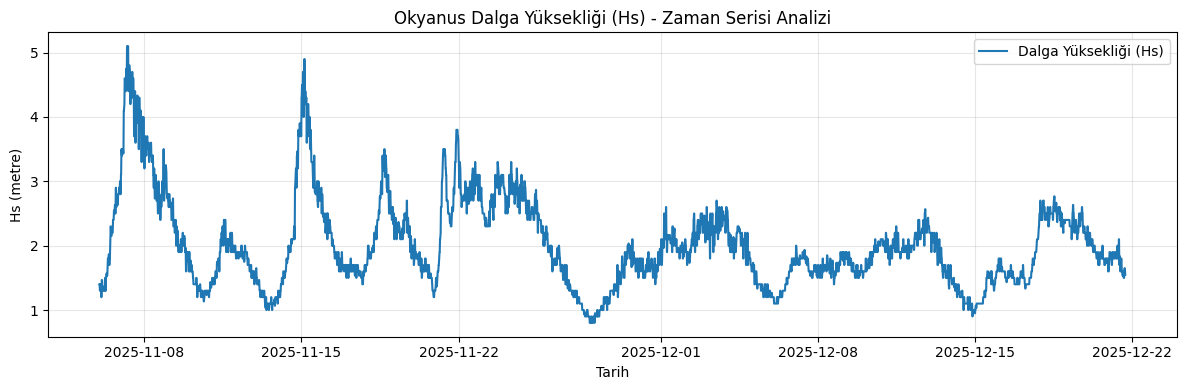

In [11]:
# Eksik veri ve gürültü temizliği
df_analiz = df_analiz.interpolate(method='linear')
df_analiz = df_analiz.ffill().bfill()
df_analiz = df_analiz.rolling(window=3, center=True).median().dropna()

# Ölçeklendirme (Standardizasyon)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_analiz), 
                         index=df_analiz.index, columns=df_analiz.columns)

# GRAFİK 1: Zaman Serisi
plt.figure(figsize=(12, 4))
plt.plot(df_analiz.index, df_analiz['Hs'], label="Dalga Yüksekliği (Hs)", color='#1f77b4')
plt.title("Okyanus Dalga Yüksekliği (Hs) - Zaman Serisi Analizi")
plt.xlabel("Tarih")
plt.ylabel("Hs (metre)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### 3. Veri Ön İşleme (Preprocessing)
Veri madenciliğinin en önemli adımı olan temizleme aşamasında:
1.  **Enterpolasyon:** Eksik veriler doldurulmuştur.
2.  **Rolling Median:** Gürültü azaltma filtresi uygulanmıştır.
3.  **Görselleştirme:** Temizlenmiş verinin zaman serisi grafiği çizdirilmiştir.

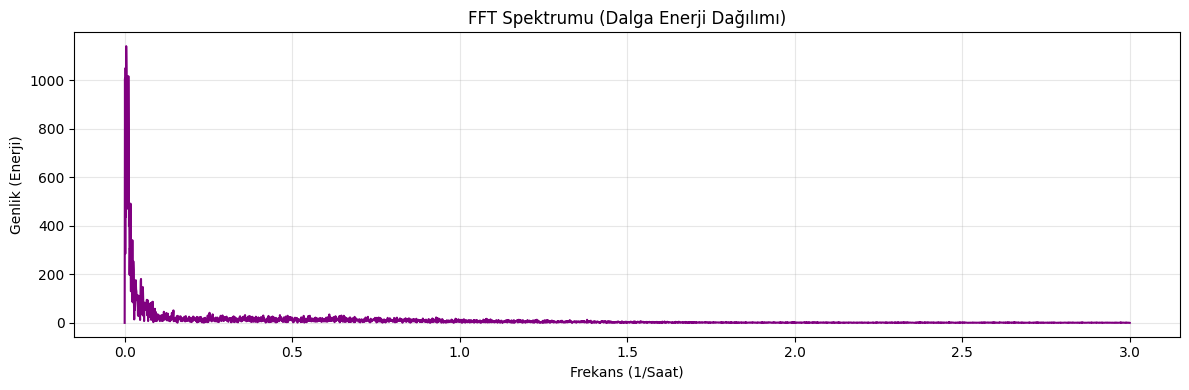

In [12]:
# Detrending (Ortalamayı çıkarma)
hs_detrended = df_analiz['Hs'] - df_analiz['Hs'].mean()

# FFT Hesaplama
fft_vals = np.abs(np.fft.rfft(hs_detrended))
fft_freq = np.fft.rfftfreq(len(hs_detrended), d=1.0/6.0) # 10dk örnekleme = saatte 6 veri

# GRAFİK 2: FFT Spektrumu
plt.figure(figsize=(12, 4))
plt.plot(fft_freq, fft_vals, color='purple')
plt.title("FFT Spektrumu (Dalga Enerji Dağılımı)")
plt.xlabel("Frekans (1/Saat)")
plt.ylabel("Genlik (Enerji)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Özellik Çıkarımı: Spektral Analiz (FFT)
Verinin frekans bileşenlerini incelemek için **Hızlı Fourier Dönüşümü (FFT)** uygulanmıştır. Bu analiz, dalgaların enerji yoğunluğunun hangi frekanslarda toplandığını gösterir.

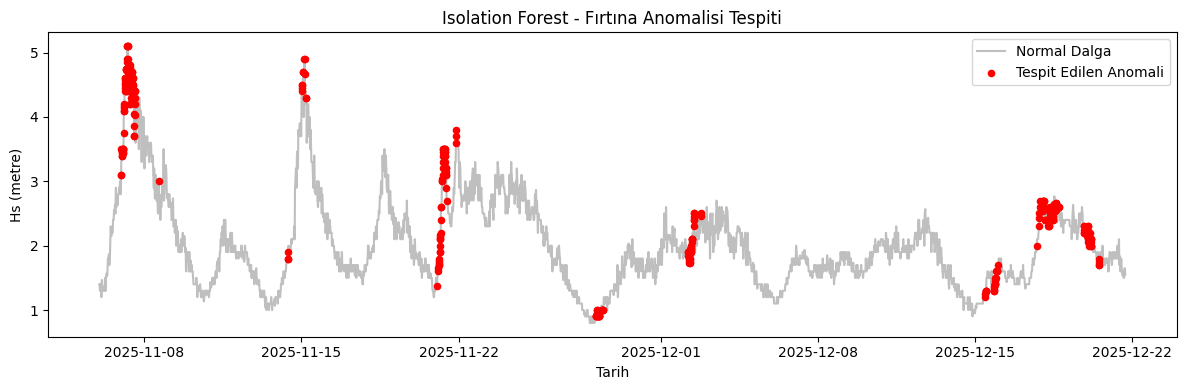

In [13]:
# Model Eğitimi (%5 anomali varsayımı)
isf = IsolationForest(contamination=0.05, random_state=42)
df_analiz['anomaly_if'] = isf.fit_predict(df_scaled)
df_analiz['score_if'] = isf.decision_function(df_scaled)

# GRAFİK 3: Anomali Tespiti
plt.figure(figsize=(12, 4))
plt.plot(df_analiz.index, df_analiz['Hs'], label="Normal Dalga", color='gray', alpha=0.5)

# Sadece anomalileri çizdir
anomalies = df_analiz[df_analiz['anomaly_if'] == -1]
plt.scatter(anomalies.index, anomalies['Hs'], color='red', label='Tespit Edilen Anomali', s=20, zorder=5)

plt.title("Isolation Forest - Fırtına Anomalisi Tespiti")
plt.xlabel("Tarih")
plt.ylabel("Hs (metre)")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Anomali Tespiti: Isolation Forest
Denetimsiz bir öğrenme algoritması olan **Isolation Forest** kullanılarak normalden sapan "fırtına" verileri tespit edilmiştir.
* **Kırmızı noktalar:** Algoritmanın tespit ettiği anomalileri gösterir.

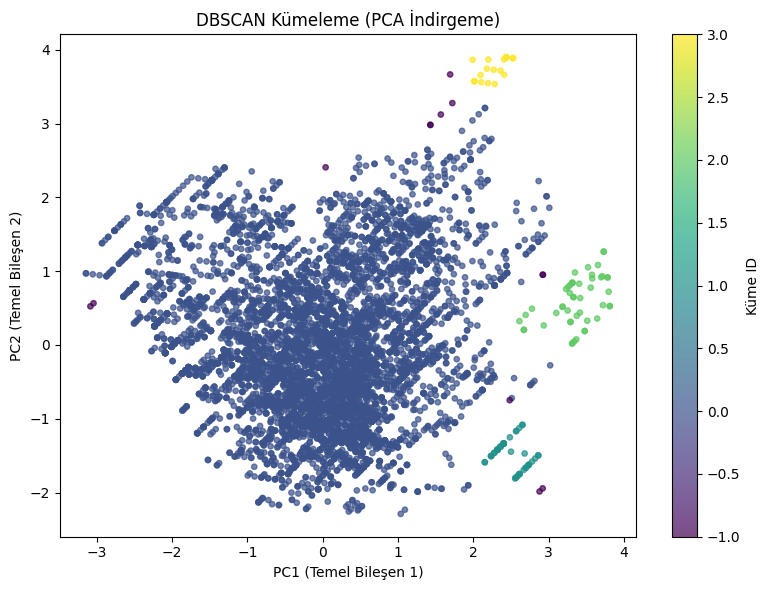

In [14]:
# PCA ile 2 Boyuta İndirgeme
pca = PCA(n_components=2)
X2 = pca.fit_transform(df_scaled)

# DBSCAN Kümeleme
db = DBSCAN(eps=0.3, min_samples=5).fit(X2)
labels = db.labels_

# GRAFİK 4: Kümeleme Sonucu
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', s=15, alpha=0.7)
plt.title("DBSCAN Kümeleme (PCA İndirgeme)")
plt.xlabel("PC1 (Temel Bileşen 1)")
plt.ylabel("PC2 (Temel Bileşen 2)")
plt.colorbar(scatter, label='Küme ID')
plt.tight_layout()
plt.show()

### 6. Kümeleme: PCA ve DBSCAN
Veri setindeki yapısal grupları belirlemek için önce **PCA** ile boyut indirgenmiş, ardından **DBSCAN** ile yoğunluk tabanlı kümeleme yapılmıştır. Farklı renkler, farklı deniz durumlarını (sakin, fırtınalı vb.) temsil eder.

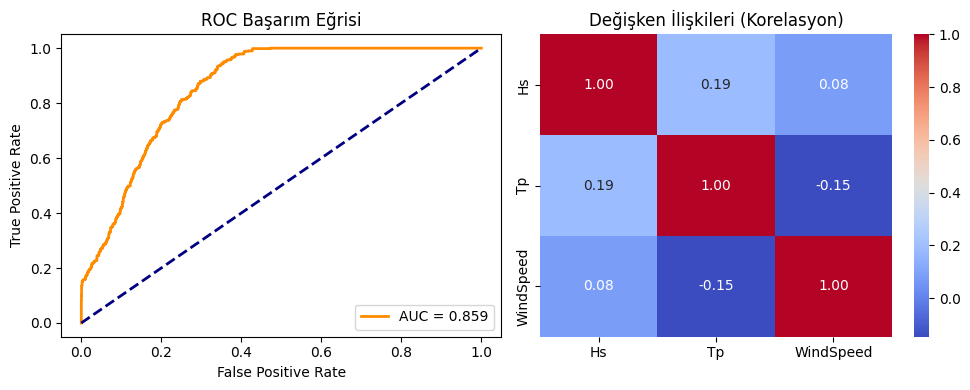

Demo tamamlandı.


In [15]:
# 1. ROC EĞRİSİ
# Basit doğrulama için en yüksek %10'luk dalgaları referans alıyoruz
true_labels = (df_analiz['Hs'] > df_analiz['Hs'].quantile(0.90)).astype(int)
fpr, tpr, _ = roc_curve(true_labels, -df_analiz['score_if'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Başarım Eğrisi")
plt.legend(loc="lower right")

# Subplot 2: Korelasyon Matrisi
plt.subplot(1, 2, 2)
sns.heatmap(df_analiz[['Hs', 'Tp', 'WindSpeed']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Değişken İlişkileri (Korelasyon)")

plt.tight_layout()
plt.show()

print("Demo tamamlandı.")

### 7. Performans Değerlendirme ve İlişki Analizi
Modelin başarımı **ROC Eğrisi** ile ölçülmüş, ayrıca değişkenler arasındaki ilişkiler **Korelasyon Matrisi** ile incelenmiştir.